## Tacotron 2 inference code 
Edit the variables **checkpoint_path** and **text** to match yours and run the entire code to generate plots of mel outputs, alignments and audio synthesis from the generated mel-spectrogram using Griffin-Lim.

#### Import libraries and setup matplotlib

In [1]:
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt

import IPython.display as ipd

import sys
sys.path.append('waveglow/')
import numpy as np
import torch

from hparams import create_hparams
from model import Tacotron2
from layers import TacotronSTFT, STFT
from audio_processing import griffin_lim
# from train_old import load_model
from train import load_model
from text import text_to_sequence, code_to_sequence
from denoiser import Denoiser
from utils import load_code_dict, load_filepaths_and_text

/data/sls/u/wnhsu/code/tacotron2_factory/tacotron2_20191017_dev/plotting_utils.py:2: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/data/sls/u/wnhsu/vtenvs/pt1.3_cp36/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/data/sls/u/wnhsu/vtenvs/pt1.3_cp36/lib/python3.6/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/data/sls/u/wnhsu/vtenvs/pt1.3_cp36/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 563

In [2]:
def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='bottom', 
                       interpolation='none')

#### Setup hparams

In [3]:
# hparams = create_hparams()
hparams = create_hparams(
    ("text_or_code=code,code_dict=./filelists/rdvq_01000_01100/code_dict_quant3"
     ",code_key=code_quant3,n_symbols=1025,collapse_code=True"))
hparams.sampling_rate = 22050

Parsing command line hparams: --text_or_code=code,--code_dict=./filelists/rdvq_01000_01100/code_dict_quant3,--code_key=code_quant3,--n_symbols=1025,--collapse_code=True


#### Load model from checkpoint

In [4]:
# checkpoint_path = "./pretrained/tacotron2_statedict.pt"
# checkpoint_path = "./exps/ljs_basic_run1/checkpoint_77000"
# checkpoint_path = "./exps/finished/ljs_code_mdl-01000-01100_vq3_run1/checkpoint_5000"
# checkpoint_path = "./exps/finished/ljs_code_mdl-01000-01100_vq3_run1/checkpoint_77000"
# checkpoint_path = "./exps/finished/ljs_code_mdl-01000-01100_vq3_chunk_run1/checkpoint_5000"
checkpoint_path = "./exps/finished/ljs_code_mdl-01000-01100_vq3_chunk_run1/checkpoint_77000"
model = load_model(hparams)
model.load_state_dict(torch.load(checkpoint_path)['state_dict'])
_ = model.cuda().eval().half()

#### Load WaveGlow for mel2audio synthesis and denoiser

In [5]:
waveglow_path = './pretrained/waveglow_256channels_new.pt'
waveglow = torch.load(waveglow_path)['model']
waveglow.cuda().eval().half()
for k in waveglow.convinv:
    k.float()
denoiser = Denoiser(waveglow)

#### Prepare text input

In [53]:
# text = "Waveglow is really awesome!"
# text = "How is the weather today? I'm thinking about going for a walk."
# sequence = np.array(text_to_sequence(text, ['english_cleaners']))[None, :]
# sequence = torch.autograd.Variable(
#     torch.from_numpy(sequence)).cuda().long()


data = load_filepaths_and_text("filelists/rdvq_01000_01100/ljs_audio_text_test_filelist.txt")  # 4
data = load_filepaths_and_text("filelists/rdvq_01000_01100/places_eng_400k_val100_filelist.txt")  # 5
data = load_filepaths_and_text("filelists/rdvq_01000_01100/flickr8k_tt.txt")
code_dict = load_code_dict(hparams.code_dict)
idx = 2
code = data[idx][hparams.code_key].split()
print('(TEXT LEN=%d) %s' % (len(data[idx]['text']), data[idx]['text']))
print('(CODE LEN=%d) %s' % (len(code), ' '.join(code)))
sequence = np.array(code_to_sequence(code, code_dict, True))[None, :]
sequence = torch.autograd.Variable(
    torch.from_numpy(sequence)).cuda().long()
ipd.display(ipd.Audio(data[idx]['audio']))

(TEXT LEN=60) A man riding a motorcycle is performing a trick at a track .
(CODE LEN=146) 263 263 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 208 208 208 263 467 467 467 467 467 5 336 336 717 803 329 971 971 337 141 536 536 536 113 827 336 224 12 12 556 466 242 398 398 337 442 526 526 133 1003 663 816 59 606 606 552 807 535 535 614 81 151 803 181 913 880 983 374 230 461 461 304 151 42 719 719 398 89 852 803 803 570 870 870 985 723 87 362 80 1022 535 27 289 501 1003 42 791 417 870 985 985 556 552 466 0 0 535 27 27 476 5 208 208 32


#### Decode text input and plot results

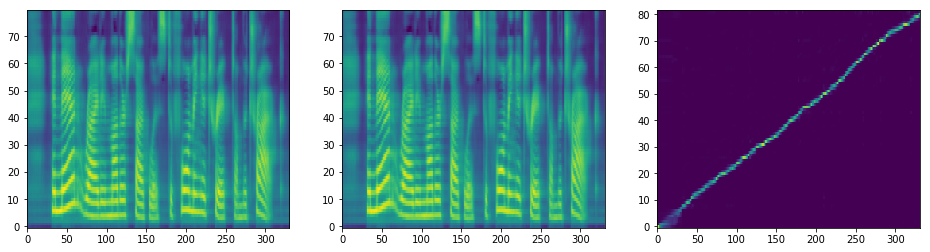

In [54]:
mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)
plot_data((mel_outputs.float().data.cpu().numpy()[0],
           mel_outputs_postnet.float().data.cpu().numpy()[0],
           alignments.float().data.cpu().numpy()[0].T))

#### Synthesize audio from spectrogram using WaveGlow

In [55]:
with torch.no_grad():
    audio = waveglow.infer(mel_outputs_postnet, sigma=0.666)
ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)

#### (Optional) Remove WaveGlow bias

In [56]:
audio_denoised = denoiser(audio, strength=0.01)[:, 0]
ipd.Audio(audio_denoised.cpu().numpy(), rate=hparams.sampling_rate) 

### Generated Code with ConvLM

##### 0


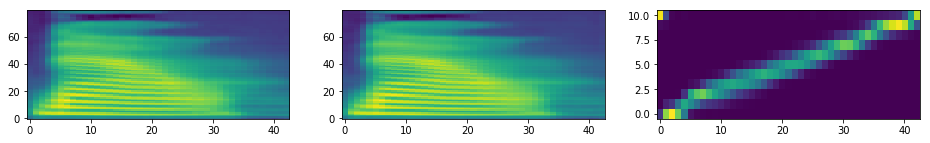

##### 1


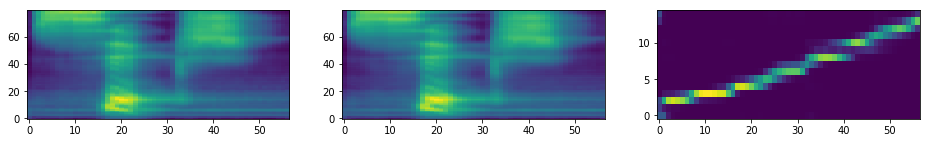

##### 2


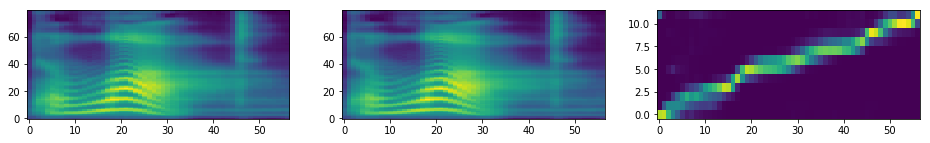

##### 3


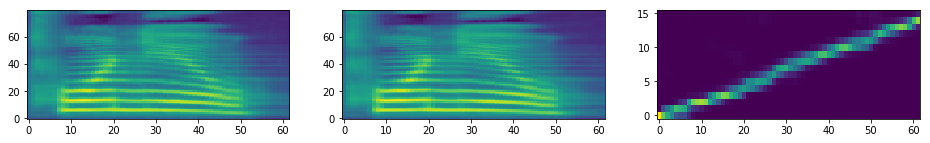

##### 4


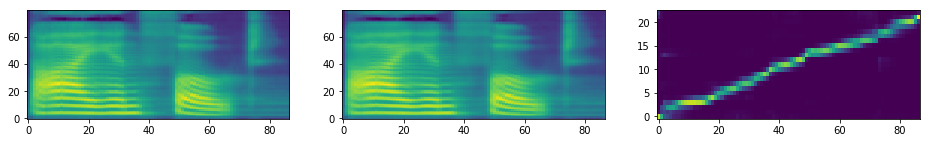

##### 5


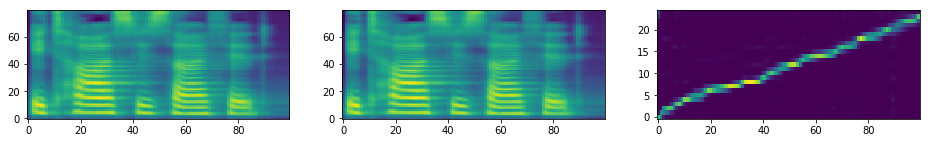

In [57]:
code_strs = [
    "336 336 717 352 892 860 689 519 519 519 135 135 769 769 5 208",
    "263 5 467 360 360 427 39 535 27 293 293 202 293 289 5 208 32",
    "263 263 717 791 151 81 81 277 595 872 872 476 476 846 336 336 263 263 263",
    "417 320 228 228 844 442 329 398 153 313 129 129 522 522 135 769 5 208 32",
    "336 100 869 552 242 803 128 128 936 580 936 59 192 863 192 44 522 522 374 27 846 336 263 208 32 32 32",
    "476 476 426 128 417 272 126 72 550 297 297 740 226 740 639 790 807 451 297 983 1009 1009 362 846 336 263 208 32",
#     "5 476 336 226 226 775 913 938 880 190 190 445 953 451 297 297 880 216 983 983 362 911 911 536 827 827 827 48 336 5 208",
#     "336 100 100 827 846 144 120 144 288 288 717 299 299 299 538 538 715 766 766 560 426 176 176 44 327 327 1022 27 27 27 476 263",
#     "336 5 336 374 582 374 746 451 913 1013 467 336 336 320 432 96 651 133 466 922 922 329 936 417 417 417 352 352 769 769 5 208",
#     "336 336 815 151 151 495 495 584 153 153 129 352 461 96 986 809 892 872 570 570 66 329 329 791 42 526 81 142 442 329 398 226 337 336 263",
#     "336 336 717 570 870 570 526 526 142 44 922 922 181 426 272 272 272 480 580 580 66 112 112 16 87 81 142 58 66 240 59 728 526 584 766 39 535 27 476 5 5",
#     "336 461 501 501 1022 288 329 329 329 110 872 224 374 494 59 374 852 329 1009 337 66 16 639 494 820 543 820 582 582 398 847 329 42 892 495 495 352 110 110 769 5",
#     "374 374 374 128 426 821 821 417 313 911 119 48 501 254 254 254 993 791 374 873 986 873 766 766 560 176 190 554 461 461 243 622 975 570 570 570 160 160 337 48 336 208",
#     "336 336 815 844 622 622 663 112 112 1009 536 827 827 374 249 502 230 543 525 277 277 277 844 1015 1015 587 202 202 202 243 703 723 556 277 595 595 0 872 476 476 5 208 32",
#     "336 336 374 791 374 809 790 174 552 329 398 129 522 522 135 815 144 128 39 685 873 320 790 844 844 181 938 880 320 432 320 242 242 362 362 740 913 913 913 1013 1013 467 208 208",
#     "336 336 717 717 717 181 938 880 457 849 892 689 327 872 42 971 526 174 174 580 119 476 96 96 703 703 892 892 16 112 112 1009 160 847 329 728 728 746 860 860 537 689 352 769 5",
#     "336 336 717 717 288 502 706 825 825 560 27 27 360 606 360 1003 103 103 453 769 5 5 5 5 5 461 190 445 445 80 80 374 374 582 59 606 606 684 962 160 846 27 289 289 476 263",
#     "336 100 288 801 1022 27 289 1013 1013 1013 1013 467 467 336 717 803 803 746 746 746 746 181 909 181 728 971 728 564 953 451 297 216 112 112 663 224 284 284 614 639 639 639 48 936 936 263 263",
#     "336 501 869 254 327 872 224 176 815 89 119 48 880 216 637 637 489 689 689 135 846 846 289 476 5 5 5 224 582 226 825 560 288 728 971 728 250 543 543 66 502 112 765 1009 654 654 846 263",
#     "336 336 717 717 494 909 909 494 564 0 0 535 426 502 778 230 909 909 869 807 807 715 584 495 156 582 502 398 313 7 7 320 873 96 703 703 445 953 297 297 639 337 936 453 336 5 208 32 32",
#     "224 224 374 362 337 329 971 329 80 1022 461 192 461 230 993 144 120 120 560 289 293 395 293 289 336 815 815 791 374 426 374 564 1022 770 809 993 892 770 243 554 84 846 289 289 289 289 476 263 208",
#     "336 100 226 226 560 426 846 42 971 971 362 766 766 362 654 582 42 962 962 740 181 360 606 606 59 129 519 42 971 971 827 827 160 962 226 663 230 320 873 873 135 341 341 454 454 181 913 913 880 1013 263",
#     "336 501 254 254 135 913 639 360 360 427 362 825 825 909 922 909 803 256 560 476 476 5 336 582 582 582 953 953 451 606 639 156 993 254 254 525 525 525 352 126 126 126 550 507 507 535 27 27 846 336 263",
#     "717 128 153 313 58 58 442 582 913 938 983 39 39 685 685 284 505 81 815 352 501 501 501 501 501 87 12 12 445 766 911 847 66 293 935 16 728 329 827 66 181 181 254 254 44 135 341 135 135 453 48 336 263 263",
#     "336 717 226 128 42 144 144 505 993 872 27 27 27 476 5 476 417 570 683 584 151 151 815 336 320 809 304 538 538 133 466 827 398 398 398 417 417 288 288 417 272 272 892 689 689 522 135 135 135 135 815 769 208 208",
#     "336 869 869 525 525 791 791 1009 801 80 654 728 728 42 129 129 706 706 427 362 911 911 740 938 913 374 791 224 176 176 538 538 505 151 852 852 1003 852 791 717 426 986 986 873 892 689 495 584 910 543 820 769 208 208",
]
for i in range(len(code_strs)):
    print('#'*5, i)
    code = code_strs[i].split()
    sequence = np.array(code_to_sequence(code, code_dict, True))[None, :]
    sequence = torch.autograd.Variable(
        torch.from_numpy(sequence)).cuda().long()

    mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)
    plot_data((mel_outputs.float().data.cpu().numpy()[0],
               mel_outputs_postnet.float().data.cpu().numpy()[0],
               alignments.float().data.cpu().numpy()[0].T),
              (16, 2))
    plt.show()

    with torch.no_grad():
        audio = waveglow.infer(mel_outputs_postnet, sigma=0.666)
#     ipd.display(ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate))

    audio_denoised = denoiser(audio, strength=0.01)[:, 0]
    ipd.display(ipd.Audio(audio_denoised.cpu().numpy(), rate=hparams.sampling_rate))